In [8]:
from getpass import getpass #std library

import numpy as np
import pylab as plt
import matplotlib
import matplotlib.pyplot as plt
from astropy import utils, io
from astropy.table import Table
from astropy.io import fits
from io import BytesIO
import requests
from tqdm import tqdm
import os
from astropy.visualization import make_lupton_rgb
%matplotlib inline

#Data lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

In [3]:
# This prints out all avaliable datasets. I think we want to use DESI
# print(qc.schema())

# We can also call schema for a specifc data release, in which it will return the tables avaliable in that dataset
# print(qc.schema('desi_edr'))

# Then we can select a table from the list to load data from
print(qc.schema('desi_edr.zpix'))


Schema: desi_edr
 Table: zpix

     Column Name   Description
     -----------   -----------
               z   Redshift measured by Redrock
            zerr   Redshift error from Redrock
            chi2   Best fit chi squared
         coeff_0   Redrock template coefficients
         coeff_1   Redrock template coefficients
         coeff_2   Redrock template coefficients
         coeff_3   Redrock template coefficients
         coeff_4   Redrock template coefficients
         coeff_5   Redrock template coefficients
         coeff_6   Redrock template coefficients
         coeff_7   Redrock template coefficients
         coeff_8   Redrock template coefficients
         coeff_9   Redrock template coefficients
       deltachi2   Delta-chi-squared for template fit from Redrock
   mean_fiber_ra   Mean (over exposures) RA of actual fiber position
  mean_fiber_dec   Mean (over exposures) DEC of actual fiber position
            elon   Ecliptic longitude
            elat   Ecliptic latitude


In [10]:
query = """
SELECT
    z.mean_fiber_ra AS ra,
    z.mean_fiber_dec AS dec,
    z.z AS redshift,
    z.zerr AS redshift_error,
    z.spectype AS spectral_type,
    z.tsnr2_lrg AS tsnr2_lrg,
    z.tsnr2_elg AS tsnr2_elg,
    p.flux_g AS flux_g,
    p.flux_r AS flux_r,
    p.flux_z AS flux_z,
    p.morphtype AS morphology,
    p.mw_transmission_g AS mw_transmission_g,
    p.mw_transmission_r AS mw_transmission_r,
    p.mw_transmission_z AS mw_transmission_z
FROM
    desi_edr.zpix AS z
JOIN
    desi_edr.photometry AS p
ON
    z.targetid = p.targetid
WHERE
    z.spectype = 'GALAXY'              -- Focus on galaxies
    AND z.z BETWEEN 0.1 AND 0.5        -- Typical redshift range for clusters
    --AND z.tsnr2_lrg > 500              -- High S/N for luminous red galaxies
    AND z.tsnr2_elg > 500              -- High S/N for emission line galaxies
    --AND p.flux_g > 0                   -- Ensure valid flux in G band
    AND p.flux_r > 0                   -- Ensure valid flux in R band
    AND p.flux_z > 0                   -- Ensure valid flux in Z band
    AND p.morphtype = 'EXP'            -- Select extended (non-stellar) sources
    AND p.mw_transmission_g > 0.8      -- Milky Way transmission cutoff for G
    AND p.mw_transmission_r > 0.8      -- Milky Way transmission cutoff for R
    AND p.mw_transmission_z > 0.8      -- Milky Way transmission cutoff for Z
LIMIT 10000
"""

# query = """
# SELECT
#     zp.z,
#     zp.zerr,
#     zp.spectype,
#     zp.tsnr2_lrg,
#     zp.tsnr2_elg
# FROM
#     desi_edr.zpix as zp
# """


results = qc.query(sql=query, fmt='pandas')
# tabulated = Table(results)
results

,ra,dec,redshift,redshift_error,spectral_type,tsnr2_lrg,tsnr2_elg,flux_g,flux_r,flux_z,morphology,mw_transmission_g,mw_transmission_r,mw_transmission_z
0,270.36978,61.112133,0.323877,0.000044,GALAXY,698.25660,600.63025,1.509713,6.301401,18.125223,EXP,0.909100,0.937822,0.964729
1,270.99545,65.986990,0.181479,0.000125,GALAXY,1312.92710,937.69650,1.187724,1.292102,1.756145,EXP,0.866259,0.907818,0.947341
2,271.21088,63.440730,0.286094,0.000013,GALAXY,737.46436,539.45750,1.715191,5.578033,15.472778,EXP,0.915611,0.942340,0.967326
3,271.41720,64.935490,0.197660,0.000009,GALAXY,435.80237,675.23267,2.246993,4.000496,5.905425,EXP,0.888350,0.923348,0.956373
4,271.06003,64.924840,0.117530,0.000006,GALAXY,963.12870,732.04010,5.211151,9.110581,11.988915,EXP,0.891657,0.925662,0.957712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,252.63725,33.775970,0.491569,0.000055,GALAXY,416.99097,626.57750,6.378339,7.720532,1.390060,EXP,0.931247,0.953151,0.973518
3857,252.69322,34.456280,0.122131,0.000018,GALAXY,610.03394,517.06890,0.648682,0.700218,0.865755,EXP,0.940406,0.959455,0.977114
3858,252.66824,35.915040,0.190195,0.000016,GALAXY,11113.65100,1868.52590,10.061838,20.181370,33.341763,EXP,0.955241,0.969625,0.982894
3859,253.60608,35.940403,0.362478,0.000014,GALAXY,934.96250,554.96750,2.029644,5.970122,14.448709,EXP,0.952548,0.967783,0.981849


In [12]:
# Example RA/DEC from query results
entries = [ # Replace with your actual RA/DEC
    {"ra": 271.701420, "dec": 61.418823},  # Example 2
]

# Output directory to save the downloaded FITS files
output_dir = "./fits_cutouts"
os.makedirs(output_dir, exist_ok=True)

# Base URL and parameters for the FITS cutout service
base_url = "https://www.legacysurvey.org/viewer/cutout.fits"
layer = "ls-dr9"  # Valid layer name
pixscale = 2.0  # Pixel scale in arcseconds per pixel

# Iterate over the entries and download FITS files
for i, entry in enumerate(entries):
    ra, dec = entry["ra"], entry["dec"]
    url = f"{base_url}?ra={ra}&dec={dec}&layer={layer}&pixscale={pixscale}"
    print(f"Fetching FITS file for Target {i+1} (RA={ra}, DEC={dec}): {url}")

    # Output file path
    output_path = os.path.join(output_dir, f"target_{i+1}.fits")

    # Fetch the FITS file
    response = requests.get(url)

    # Validate and save the FITS file
    if response.status_code == 200 and "fits" in response.headers.get("Content-Type", "").lower():
        with open(output_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded FITS file successfully: {output_path}")
    else:
        print(f"Failed to fetch FITS file for Target {i+1}. HTTP Status: {response.status_code}")
        print(f"Response Headers: {response.headers}")
        print(f"Response Content (snippet): {response.text[:500]}")  # For debugging




Fetching FITS file for Target 1 (RA=271.70142, DEC=61.418823): https://www.legacysurvey.org/viewer/cutout.fits?ra=271.70142&dec=61.418823&layer=ls-dr9&pixscale=2.0
Downloaded FITS file successfully: ./fits_cutouts/target_1.fits



FITS File Structure:
Filename: ./fits_cutouts/target_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (256, 256, 3)   float32   

Primary Header:
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                    3 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
SURVEY  = 'LegacySurvey'                                      

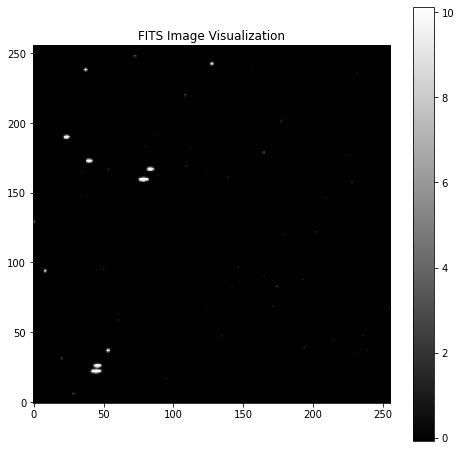

In [13]:
fits_file = "./fits_cutouts/target_1.fits"  

# Open the FITS file
try:
    with fits.open(fits_file) as hdul:
        # Print the structure of the FITS file
        print("\nFITS File Structure:")
        hdul.info()

        # Access the primary HDU (Header Data Unit)
        primary_hdu = hdul[0]
        image_data = primary_hdu.data

        # Print header information for metadata
        print("\nPrimary Header:")
        print(repr(primary_hdu.header))

        # Verify the image data
        if image_data is not None:
            print(f"Image data shape: {image_data.shape}")
            
            # Display the image
            plt.figure(figsize=(8, 8))
            plt.imshow(image_data[0], cmap="gray", origin="lower")  # Use image_data[0] for RGB
            plt.colorbar()
            plt.title("FITS Image Visualization")
            plt.show()
        else:
            print("No image data found in the primary HDU.")
except Exception as e:
    print(f"An error occurred: {e}")

In [14]:

ra = 271.8270  # Replace with RA from the viewer
dec = 61.2231  # Replace with DEC from the viewer
layer = "ls-dr9"  # Layer from the viewer
pixscale = 0.262  # Adjust pixel scale for desired resolution
size = 512  # Size of the image in pixels (512x512)

# Construct the URL
url = f"https://www.legacysurvey.org/viewer/cutout.fits?ra={ra}&dec={dec}&layer={layer}&pixscale={pixscale}&size={size}"
print(f"Fetching FITS file from: {url}")

# Output file path
output_dir = "./fits_cutouts"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "test_target2.fits")

# Fetch the FITS file
response = requests.get(url)

# Validate and save the FITS file
if response.status_code == 200 and "fits" in response.headers.get("Content-Type", "").lower():
    with open(output_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded FITS file successfully: {output_path}")
else:
    print(f"Failed to fetch FITS file. HTTP Status: {response.status_code}")
    print(f"Response Headers: {response.headers}")
    print(f"Response Content (snippet): {response.text[:500]}")


Fetching FITS file from: https://www.legacysurvey.org/viewer/cutout.fits?ra=271.827&dec=61.2231&layer=ls-dr9&pixscale=0.262&size=512
Downloaded FITS file successfully: ./fits_cutouts/test_target2.fits


Filename: ./fits_cutouts/test_target2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (512, 512, 3)   float32   
Image data shape: (3, 512, 512)


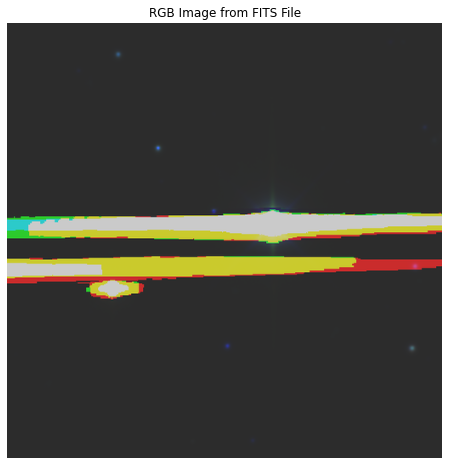

In [16]:

fits_file = "./fits_cutouts/test_target2.fits"  # Replace with the correct file path

# Open the FITS file
with fits.open(fits_file) as hdul:
    hdul.info()  # Print FITS structure
    image_data = hdul[0].data  # Extract the image data

# Check the shape of the image data
print(f"Image data shape: {image_data.shape}")

# Handle multi-channel data (3D array)
if len(image_data.shape) == 3:
    # Combine RGB channels into a single image for visualization
    rgb_image = np.stack([image_data[0], image_data[1], image_data[2]], axis=-1)

    # Normalize the data for display
    rgb_image = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))

    # Display the combined RGB image
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image, origin="lower")
    plt.title("RGB Image from FITS File")
    plt.axis("off")
    plt.show()
else:
    # If it's already a 2D image, plot directly
    plt.figure(figsize=(8, 8))
    plt.imshow(image_data, cmap="gray", origin="lower")
    plt.colorbar()
    plt.title("Grayscale Image from FITS File")
    plt.show()

